In [171]:
import sys
sys.path.append('/Users/zhoupeng/Desktop/crypto_assets_pricing')

In [172]:
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings('ignore')

from api.ashare import TushareDataHandler

In [173]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 配色方案
color_map = plt.get_cmap('Set1')
color_map_alpha = plt.get_cmap('Pastel1')
plt.rc('font', family='Arial')  # or 'sans-serif' 根据需要选

regular_font = fm.FontProperties(fname='/System/Library/Fonts/Supplemental/Arial.ttf', size=12)
legend_font = fm.FontProperties(fname='/System/Library/Fonts/Supplemental/Arial.ttf', size=10)
bold_font = fm.FontProperties(fname='/System/Library/Fonts/Supplemental/Arial Bold.ttf', size=12)
italics_font = fm.FontProperties(fname='/System/Library/Fonts/Supplemental/Arial Italic.ttf', size=12)

In [174]:
# 获取数据
# tushare获取数据
# data_handler = TushareDataHandler(start_date='20200101', end_date='20250101', token="")

#stock_list = data_handler.get_index_list(index_code='000300.SH') # 沪深300指数
#stock_list = list(set(stock_list))

#prices_df = data_handler.get_prices_from_tushare(stock_list, fields=['close', 'vol'], sleep_time=1)
#factors_df = data_handler.get_factors_from_tushare(stock_list, factors=['total_mv'], sleep_time=1)

In [175]:
prices_df = pd.read_hdf('/Users/zhoupeng/Desktop/crypto_assets_pricing/data/hs300_prices.h5', 'prices')
factors_df = pd.read_hdf('/Users/zhoupeng/Desktop/crypto_assets_pricing/data/hs300_factors.h5', 'factors')

# 1. 数据获取与预处理

In [176]:
close_prices = prices_df.xs('Close', level=1, axis=1)
close_prices.reset_index(inplace=True)
close_prices = close_prices.rename(columns={'index': 'trade_date'})

volume_prices = prices_df.xs('Volume', level=1, axis=1)
volume_prices.reset_index(inplace=True)
volume_prices = volume_prices.rename(columns={'index': 'trade_date'})

totalmv_prices = factors_df.xs('total_mv', level=1, axis=1)
totalmv_prices.reset_index(inplace=True)
totalmv_prices = totalmv_prices.rename(columns={'index': 'trade_date'})

In [177]:
# 重塑收盘价数据
close_df_melted = close_prices.melt(
    id_vars=['trade_date'],
    var_name='code',
    value_name='close'
)
    
# 重塑成交量数据
volume_df_melted = volume_prices.melt(
    id_vars=['trade_date'],
    var_name='code',
    value_name='volume'
)
    
# 重塑总市值数据
totalmv_df_melted = totalmv_prices.melt(
    id_vars=['trade_date'],
    var_name='code',
    value_name='total_mv'
)
    
# 合并所有数据
merged_df = pd.merge(
    close_df_melted,
    volume_df_melted,
    on=['trade_date', 'code'],
    how='left'
)
    
merged_df = pd.merge(
    merged_df,
    totalmv_df_melted,
    on=['trade_date', 'code'],
    how='left'
)
    
# 合并成多重索引
combined_df = merged_df.set_index(['trade_date', 'code'])

In [178]:
combined_df
# combined_df.loc[('2024-01-02', '000069.SZ'), 'close']

,,close,volume,total_mv
trade_date,code,,,
2020-01-02,688363.SH,85.03,24884.47,4.081440e+06
2020-01-03,688363.SH,83.36,21845.88,4.001280e+06
2020-01-06,688363.SH,84.00,19395.07,4.032000e+06
2020-01-07,688363.SH,84.27,21652.91,4.044960e+06
2020-01-08,688363.SH,82.22,18320.00,3.946560e+06
...,...,...,...,...
2024-12-25,000617.SZ,7.14,494962.01,9.026444e+06
2024-12-26,000617.SZ,7.09,427915.00,8.963234e+06
2024-12-27,000617.SZ,7.16,873826.50,9.051729e+06


In [179]:
combined_df = combined_df.reset_index()
combined_df['trade_date'] = pd.to_datetime(combined_df['trade_date'])

# 添加年份列
combined_df['year'] = combined_df['trade_date'].dt.year

print("Date range:")
print(f"Start date: {combined_df['trade_date'].min()}")
print(f"End date: {combined_df['trade_date'].max()}")

Date range:
Start date: 2020-01-02 00:00:00
End date: 2024-12-31 00:00:00


In [180]:
combined_df

,trade_date,code,close,volume,total_mv,year
0,2020-01-02,688363.SH,85.03,24884.47,4.081440e+06,2020
1,2020-01-03,688363.SH,83.36,21845.88,4.001280e+06,2020
2,2020-01-06,688363.SH,84.00,19395.07,4.032000e+06,2020
3,2020-01-07,688363.SH,84.27,21652.91,4.044960e+06,2020
4,2020-01-08,688363.SH,82.22,18320.00,3.946560e+06,2020
...,...,...,...,...,...,...
397531,2024-12-25,000617.SZ,7.14,494962.01,9.026444e+06,2024
397532,2024-12-26,000617.SZ,7.09,427915.00,8.963234e+06,2024
397533,2024-12-27,000617.SZ,7.16,873826.50,9.051729e+06,2024
397534,2024-12-30,000617.SZ,7.18,570160.05,9.077013e+06,2024


In [181]:
# 确保数据按日期和代码排序，不然group可能会出错
combined_df = combined_df.sort_values(['trade_date', 'code'])

# 计算周数
combined_df['days_from_year_start'] = combined_df.groupby('year').apply(
    lambda x: (x['trade_date'] - pd.to_datetime(str(x.name) + '-01-01')).dt.days
).reset_index(level=0, drop=True)

combined_df['week'] = (combined_df['days_from_year_start'] // 7 + 1)
combined_df.loc[combined_df['week'] > 52, 'week'] = 52

combined_df = combined_df.set_index(['year', 'week', 'code'])

# 按周获取最后一个交易日的数据，以及平均成交量和总市值
weekly_data = combined_df.groupby(['year', 'week', 'code']).agg({
    'close': 'last',
    'volume': 'mean',
    'total_mv': 'mean'
}).reset_index()

# 计算周收益率
weekly_data = weekly_data.sort_values(['code', 'year', 'week'])
weekly_data['return'] = weekly_data.groupby('code')['close'].pct_change() # 周回报率

weekly_data = weekly_data.set_index(['year', 'week', 'code'])

weekly_data.columns = ['close', 'avg_volume', 'avg_mv', 'return']

In [182]:
weekly_data

close    avg_volume        avg_mv    return
year week code                                                  
2020 1    000001.SZ  17.15  1.059279e+06  3.312105e+07       NaN
     2    000001.SZ  16.76  9.283272e+05  3.255925e+07 -0.022741
     3    000001.SZ  16.00  8.271317e+05  3.170539e+07 -0.045346
     4    000001.SZ  15.54  9.100285e+05  3.069046e+07 -0.028750
     5    000001.SZ  14.60  1.982683e+06  2.774076e+07 -0.060489
...                    ...           ...           ...       ...
2024 48   688981.SH  90.10  6.775010e+05  6.961176e+07  0.014983
     49   688981.SH  88.93  5.688667e+05  7.023506e+07 -0.012986
     50   688981.SH  82.99  5.572755e+05  6.887026e+07 -0.066794
     51   688981.SH  94.28  7.617225e+05  6.808080e+07  0.136040
     52   688981.SH  94.62  9.992433e+05  7.726931e+07  0.003606

[83312 rows x 4 columns]

In [183]:
combined_df

trade_date   close      volume      total_mv  \
year week code                                                     
2020 1    000001.SZ 2020-01-02   16.87  1530231.87  3.273778e+07   
          000002.SZ 2020-01-02   32.56  1012130.40  3.679978e+07   
          000063.SZ 2020-01-02   35.45  1014254.88  1.498623e+07   
          000069.SZ 2020-01-02    7.78   779758.69  6.381550e+06   
          000100.SZ 2020-01-02    4.57  3649741.48  6.182496e+06   
...                        ...     ...         ...           ...   
2024 52   688472.SH 2024-12-31   12.56   449941.77  4.632401e+06   
          688506.SH 2024-12-31  191.73     7501.40  7.688373e+06   
          688561.SH 2024-12-31   26.83    63582.41  1.838317e+06   
          688599.SH 2024-12-31   19.30   186588.30  4.206175e+06   
          688981.SH 2024-12-31   94.62   878237.97  7.546456e+07   

                     days_from_year_start  
year week code                             
2020 1    000001.SZ                     1  
          000002.SZ                     1  
          000063.SZ                     1  
          000069.SZ                     1  
          000100.SZ                     1  
...                                   ...  
2024 52   688472.SH                   365  
          688506.SH                   365  
          688561.SH                   365  
          688599.SH                   365  
          688981.SH                   365  

[397536 rows x 5 columns]

In [184]:
# 验证数据
print("Checking first few weeks of 2020:")
for week in range(1, 5):
    print(f"\nWeek {week}:")
    print(weekly_data.loc[(2020, week)].head())

# 检查每周的股票数量
stocks_per_week = weekly_data.groupby(['year', 'week']).size()
print("\nNumber of stocks per week:")
print(stocks_per_week.describe())

# 检查2020年第一个月的周数分布
print("\nFirst month of 2020 - week distribution:")
early_2020 = combined_df.loc[2020].reset_index()
print(early_2020[early_2020['trade_date'] <= '2020-01-31'][['trade_date', 'week']].drop_duplicates())

Checking first few weeks of 2020:

Week 1:
           close    avg_volume        avg_mv  return
code                                                
000001.SZ  17.15  1.059279e+06  3.312105e+07     NaN
000002.SZ  31.76  8.181102e+05  3.613295e+07     NaN
000063.SZ  36.60  1.191666e+06  1.535632e+07     NaN
000069.SZ   7.84  5.051265e+05  6.385651e+06     NaN
000100.SZ   4.57  3.338183e+06  6.223082e+06     NaN

Week 2:
           close   avg_volume        avg_mv    return
code                                                 
000001.SZ  16.76   928327.248  3.255925e+07 -0.022741
000002.SZ  31.39   582327.286  3.580745e+07 -0.011650
000063.SZ  36.71   945680.450  1.562157e+07  0.003005
000069.SZ   7.82   378118.524  6.335616e+06 -0.002551
000100.SZ   4.87  4559044.614  6.442243e+06  0.065646

Week 3:
           close   avg_volume        avg_mv    return
code                                                 
000001.SZ  16.00   827131.666  3.170539e+07 -0.045346
000002.SZ  29.21   692033.28

In [185]:
# 存储市场回报
market_returns = []

# 获取所有唯一的年份和周数
years = weekly_data.index.get_level_values('year').unique()
weeks = weekly_data.index.get_level_values('week').unique()

# 计算每周的市场回报
for year in years:
    for week in weeks:
        try:
            # 获取当周的数据
            week_data = weekly_data.loc[(year, week)]

            # 如果是每年的第一周，市场回报应该是NaN
            if week == 1:
                mkt_return = np.nan
            
            else:
                # 计算总市值
                total_mv = week_data['avg_mv'].sum()
                
                # 计算每个股票的市值权重
                weights = week_data['avg_mv'] / total_mv
                
                # 计算市值加权的市场收益率
                mkt_return = (week_data['return'] * weights).sum()
                
            market_returns.append({
                'year': year,
                'week': week,
                'mkt_return': mkt_return
            })
        except KeyError:
            continue  # 跳过不存在的年周组合

market_return_df = pd.DataFrame(market_returns)
market_return_df = market_return_df.set_index(['year', 'week'])

# 添加到原始数据
weekly_data = weekly_data.reset_index()
weekly_data = weekly_data.merge(
    market_return_df.reset_index(), 
    on=['year', 'week'], 
    how='left'
)
weekly_data = weekly_data.set_index(['year', 'week', 'code'])

In [186]:
# 检查结果
print("Market returns summary:")
print(market_return_df.describe())

print("\nFirst few weeks of market returns:")
print(market_return_df.head(10))

print("\nFinal data structure:")
print(weekly_data.head(10))

Market returns summary:
       mkt_return
count  249.000000
mean     0.001866
std      0.024279
min     -0.077092
25%     -0.012591
50%      0.001371
75%      0.014278
max      0.134972

First few weeks of market returns:
           mkt_return
year week            
2020 1            NaN
     2       0.005346
     3      -0.013273
     4      -0.019375
     5      -0.048454
     6       0.040414
     7       0.026720
     8       0.013446
     9      -0.008154
     10     -0.005035

Final data structure:
                     close   avg_volume        avg_mv    return  mkt_return
year week code                                                             
2020 1    000001.SZ  17.15  1059279.435  3.312105e+07       NaN         NaN
     2    000001.SZ  16.76   928327.248  3.255925e+07 -0.022741    0.005346
     3    000001.SZ  16.00   827131.666  3.170539e+07 -0.045346   -0.013273
     4    000001.SZ  15.54   910028.490  3.069046e+07 -0.028750   -0.019375
     5    000001.SZ  14.60  1982683

In [187]:
weekly_data

close    avg_volume        avg_mv    return  mkt_return
year week code                                                              
2020 1    000001.SZ  17.15  1.059279e+06  3.312105e+07       NaN         NaN
     2    000001.SZ  16.76  9.283272e+05  3.255925e+07 -0.022741    0.005346
     3    000001.SZ  16.00  8.271317e+05  3.170539e+07 -0.045346   -0.013273
     4    000001.SZ  15.54  9.100285e+05  3.069046e+07 -0.028750   -0.019375
     5    000001.SZ  14.60  1.982683e+06  2.774076e+07 -0.060489   -0.048454
...                    ...           ...           ...       ...         ...
2024 48   688981.SH  90.10  6.775010e+05  6.961176e+07  0.014983    0.013960
     49   688981.SH  88.93  5.688667e+05  7.023506e+07 -0.012986    0.019965
     50   688981.SH  82.99  5.572755e+05  6.887026e+07 -0.066794   -0.006580
     51   688981.SH  94.28  7.617225e+05  6.808080e+07  0.136040    0.001766
     52   688981.SH  94.62  9.992433e+05  7.726931e+07  0.003606    0.015651

[83312 rows x 5 columns]

In [188]:
weekly_data.loc[(2023, 7), ]

,close,avg_volume,avg_mv,return,mkt_return
code,,,,,
000001.SZ,13.43,1231544.442,2.657835e+07,-0.039342,-0.011512
000002.SZ,17.09,643945.668,2.026767e+07,-0.032824,-0.011512
000063.SZ,27.97,647666.918,1.358033e+07,-0.008156,-0.011512
000069.SZ,5.22,540525.240,4.432249e+06,-0.013233,-0.011512
000100.SZ,4.30,4074391.878,7.371643e+06,0.023810,-0.011512
...,...,...,...,...,...
688472.SH,NaN,NaN,NaN,NaN,-0.011512
688506.SH,72.00,23867.638,3.037655e+06,-0.044966,-0.011512
688561.SH,73.46,38220.762,5.216757e+06,-0.022228,-0.011512


# 2. 因子构造

In [189]:
# Size类因子
# 1. MCAP: Log last-day market capitalization
weekly_data['MCAP'] = np.log(weekly_data['avg_mv'])

# 2. PRC: Log last-day price
weekly_data['PRC'] = np.log(weekly_data['close'])

# 3. MAXDPRC: Maximum price of the portfolio formation week
# 需要用到原始数据来计算每周的最高价
max_price = combined_df.groupby(['year', 'week', 'code'])['close'].max()
weekly_data['MAXDPRC'] = max_price

# Mom类因子
# 1. Past 1-week return (r 1,0)
weekly_data['r_1_0'] = weekly_data['return']

# 重置索引来处理多周期收益率
df_temp = weekly_data.reset_index()
df_temp = df_temp.sort_values(['code', 'year', 'week'])

# 2. Past 2-week return (r 2,0)
df_temp['r_2_0'] = df_temp.groupby('code')['return'].transform(
    lambda x: (1 + x).rolling(window=2).apply(lambda y: np.prod(y) - 1, raw=True)
)

# 3. Past 3-week return (r 3,0)
df_temp['r_3_0'] = df_temp.groupby('code')['return'].transform(
    lambda x: (1 + x).rolling(window=3).apply(lambda y: np.prod(y) - 1, raw=True)
)

# 4. Past 4-week return (r 4,0)
df_temp['r_4_0'] = df_temp.groupby('code')['return'].transform(
    lambda x: (1 + x).rolling(window=4).apply(lambda y: np.prod(y) - 1, raw=True)
)

# 将新的列加回weekly_data
weekly_data = df_temp.set_index(['year', 'week', 'code'])

# Vol类因子
# 1. VOL: Log average daily volume
weekly_data['VOL'] = np.log(weekly_data['avg_volume'])

# 2. PRCVOL: Log average daily volume times price
weekly_data['PRCVOL'] = np.log(weekly_data['avg_volume'] * weekly_data['close'])

# 3. VOLSCALED: Log average daily volume times price scaled by market capitalization
weekly_data['VOLSCALED'] = np.log(weekly_data['avg_volume'] * weekly_data['close'] / weekly_data['avg_mv'])

# 查看结果
# print("First few rows with momentum factors:")
# print(weekly_data[['return', 'r_1_0', 'r_2_0']].head(10))


In [190]:
weekly_data

close    avg_volume        avg_mv    return  mkt_return  \
year week code                                                                 
2020 1    000001.SZ  17.15  1.059279e+06  3.312105e+07       NaN         NaN   
     2    000001.SZ  16.76  9.283272e+05  3.255925e+07 -0.022741    0.005346   
     3    000001.SZ  16.00  8.271317e+05  3.170539e+07 -0.045346   -0.013273   
     4    000001.SZ  15.54  9.100285e+05  3.069046e+07 -0.028750   -0.019375   
     5    000001.SZ  14.60  1.982683e+06  2.774076e+07 -0.060489   -0.048454   
...                    ...           ...           ...       ...         ...   
2024 48   688981.SH  90.10  6.775010e+05  6.961176e+07  0.014983    0.013960   
     49   688981.SH  88.93  5.688667e+05  7.023506e+07 -0.012986    0.019965   
     50   688981.SH  82.99  5.572755e+05  6.887026e+07 -0.066794   -0.006580   
     51   688981.SH  94.28  7.617225e+05  6.808080e+07  0.136040    0.001766   
     52   688981.SH  94.62  9.992433e+05  7.726931e+07  0.003606    0.015651   

                          MCAP       PRC  MAXDPRC     r_1_0     r_2_0  \
year week code                                                          
2020 1    000001.SZ  17.315680  2.841998    17.18       NaN       NaN   
     2    000001.SZ  17.298572  2.818995    16.99 -0.022741       NaN   
     3    000001.SZ  17.271997  2.772589    16.52 -0.045346 -0.067055   
     4    000001.SZ  17.239462  2.743417    16.09 -0.028750 -0.072792   
     5    000001.SZ  17.138413  2.681022    14.60 -0.060489 -0.087500   
...                        ...       ...      ...       ...       ...   
2024 48   688981.SH  18.058444  4.500920    90.10  0.014983 -0.050680   
     49   688981.SH  18.067358  4.487850    89.49 -0.012986  0.001802   
     50   688981.SH  18.047735  4.418720    88.00 -0.066794 -0.078912   
     51   688981.SH  18.036206  4.546269    94.28  0.136040  0.060160   
     52   688981.SH  18.162807  4.549869    99.29  0.003606  0.140137   

                        r_3_0     r_4_0        VOL     PRCVOL  VOLSCALED  
year week code                                                            
2020 1    000001.SZ       NaN       NaN  13.873099  16.715098  -0.600582  
     2    000001.SZ       NaN       NaN  13.741140  16.560135  -0.738437  
     3    000001.SZ       NaN       NaN  13.625719  16.398308  -0.873689  
     4    000001.SZ -0.093878       NaN  13.721231  16.464649  -0.774814  
     5    000001.SZ -0.128878 -0.148688  14.499962  17.180983   0.042570  
...                       ...       ...        ...        ...        ...  
2024 48   688981.SH -0.101695  0.062375  13.426166  17.927086  -0.131358  
     49   688981.SH -0.063007 -0.113360  13.251401  17.739251  -0.328107  
     50   688981.SH -0.065112 -0.125593  13.230815  17.649535  -0.398200  
     51   688981.SH  0.046393  0.062071  13.543338  18.089607   0.053401  
     52   688981.SH  0.063983  0.050166  13.814754  18.364622   0.201815  

[83312 rows x 15 columns]

In [191]:
combined_df

trade_date   close      volume      total_mv  \
year week code                                                     
2020 1    000001.SZ 2020-01-02   16.87  1530231.87  3.273778e+07   
          000002.SZ 2020-01-02   32.56  1012130.40  3.679978e+07   
          000063.SZ 2020-01-02   35.45  1014254.88  1.498623e+07   
          000069.SZ 2020-01-02    7.78   779758.69  6.381550e+06   
          000100.SZ 2020-01-02    4.57  3649741.48  6.182496e+06   
...                        ...     ...         ...           ...   
2024 52   688472.SH 2024-12-31   12.56   449941.77  4.632401e+06   
          688506.SH 2024-12-31  191.73     7501.40  7.688373e+06   
          688561.SH 2024-12-31   26.83    63582.41  1.838317e+06   
          688599.SH 2024-12-31   19.30   186588.30  4.206175e+06   
          688981.SH 2024-12-31   94.62   878237.97  7.546456e+07   

                     days_from_year_start  
year week code                             
2020 1    000001.SZ                     1  
          000002.SZ                     1  
          000063.SZ                     1  
          000069.SZ                     1  
          000100.SZ                     1  
...                                   ...  
2024 52   688472.SH                   365  
          688506.SH                   365  
          688561.SH                   365  
          688599.SH                   365  
          688981.SH                   365  

[397536 rows x 5 columns]

In [192]:
# 有些因子需要从日频里构造而非周频，因此我们需要使用combined_df来构造，这是最完整的数据集

def prepare_daily_returns(combined_df):
    """
    从合并数据中准备日频收益率数据
    """
    # 重设索引，提取需要的列
    daily_data = combined_df.reset_index()[['trade_date', 'code', 'close', 'total_mv']]
    
    daily_data['trade_date'] = pd.to_datetime(daily_data['trade_date'])
    
    # 按日期和代码排序
    daily_data = daily_data.sort_values(['trade_date', 'code'])
    
    # 计算个股日收益率
    daily_data['return'] = daily_data.groupby('code')['close'].pct_change()
    
    # 计算市值加权的市场收益率
    # 1. 计算每日每只股票的市值权重
    daily_data['mv_weight'] = daily_data.groupby('trade_date')['total_mv'].transform(
        lambda x: x / x.sum())
    
    # 2. 计算市值加权的市场收益率
    # 只使用有收益率的股票计算市场收益率
    mkt_returns = daily_data.groupby('trade_date').apply(
        lambda x: (x['return'] * x['mv_weight']).sum() if x['return'].notna().any() else np.nan
    ).to_dict()
    
    # 3. 将市场收益率映射回每只股票
    daily_data['mkt_return'] = daily_data['trade_date'].map(mkt_returns)
    
    # 设置MultiIndex
    daily_returns = daily_data.set_index(['trade_date', 'code'])[['return', 'mkt_return']]
    
    return daily_returns

# 计算日频收益率
daily_returns = prepare_daily_returns(combined_df)

In [193]:
daily_returns 

return  mkt_return
trade_date code                           
2020-01-02 000001.SZ       NaN         NaN
           000002.SZ       NaN         NaN
           000063.SZ       NaN         NaN
           000069.SZ       NaN         NaN
           000100.SZ       NaN         NaN
...                        ...         ...
2024-12-31 688472.SH  0.031199   -0.011931
           688506.SH -0.005085   -0.011931
           688561.SH -0.050602   -0.011931
           688599.SH -0.035964   -0.011931
           688981.SH -0.047034   -0.011931

[397536 rows x 2 columns]

In [194]:
print("Date range in daily_returns:")
print("Start date:", daily_returns.index.get_level_values(0).min())
print("End date:", daily_returns.index.get_level_values(0).max())

# 检查000001.SZ的前几个交易日数据
print("\nFirst few days of 000001.SZ:")
test_stock = '000001.SZ'
stock_data = daily_returns.loc[(slice(None), test_stock), :].reset_index(level=1, drop=True)
print(stock_data.head(10))

Date range in daily_returns:
Start date: 2020-01-02 00:00:00
End date: 2024-12-31 00:00:00

First few days of 000001.SZ:
              return  mkt_return
trade_date                      
2020-01-02       NaN         NaN
2020-01-03  0.018376   -0.001263
2020-01-06 -0.006403   -0.002307
2020-01-07  0.004687    0.005670
2020-01-08 -0.028571   -0.010282
2020-01-09  0.007803    0.010509
2020-01-10 -0.005956   -0.000152
2020-01-13  0.017975    0.009114
2020-01-14 -0.013537   -0.003232
2020-01-15 -0.014320   -0.005024


In [195]:
def calculate_beta_for_stock(stock_returns, window=365):
    """
    计算单个股票的BETA, BETA2和IDIOVOL
    """
    
    from scipy import stats
    import numpy as np
    
    # 初始化结果列表
    results = []
    
    # 获取排序后的日期序列
    dates = sorted(stock_returns.index.unique())
    
    # 使用滚动窗口计算beta
    for i in range(len(dates)-window+1):
        # 获取窗口期数据
        window_dates = dates[i:i+window]
        end_date = window_dates[-1]
        window_data = stock_returns.loc[window_dates]
        
        # 确保有足够的有效数据（至少75%的数据点）
        valid_data = window_data.dropna()
        if len(valid_data) >= window * 0.75:
            y = window_data['return']
            X = window_data['mkt_return']
            
            # 去除任一变量为NaN的观测
            mask = ~(np.isnan(X) | np.isnan(y))
            X = X[mask]
            y = y[mask]
            
            # 运行回归
            slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)
            
            # 计算残差
            y_pred = slope * X + intercept
            residuals = y - y_pred
            idiovol = np.std(residuals)
            
            results.append({
                'date': end_date,
                'BETA': slope,
                'BETA2': slope ** 2,
                'IDIOVOL': idiovol,
                'valid_obs': len(X)  # 添加有效观测数
            })
    
    if not results:
        print("No valid beta calculations!")
        return pd.DataFrame()
    
    result_df = pd.DataFrame(results).set_index('date')
    
    return result_df[['BETA', 'BETA2', 'IDIOVOL']]

# 测试函数
test_stock = '000001.SZ'
stock_data = daily_returns.loc[(slice(None), test_stock), :].reset_index(level=1, drop=True)
print(f"\nCalculating betas for {test_stock}...")
beta_results = calculate_beta_for_stock(stock_data)
print("\nFirst few beta calculations:")
print(beta_results.head())


Calculating betas for 000001.SZ...

First few beta calculations:
                BETA     BETA2   IDIOVOL
date                                    
2021-07-06  1.088289  1.184372  0.018592
2021-07-07  1.084618  1.176397  0.018603
2021-07-08  1.091088  1.190474  0.018673
2021-07-09  1.091412  1.191181  0.018675
2021-07-12  1.088624  1.185102  0.018697


In [196]:
def calculate_risk_factors(daily_returns, window_days=365):
    """
    计算所有股票的BETA, BETA2和IDIOVOL因子
    """
    # 获取所有股票代码
    stocks = daily_returns.index.get_level_values('code').unique()
    print(f"Processing {len(stocks)} stocks...")
    
    # 存储所有股票的结果
    all_results = []
    
    # 对每只股票计算因子
    for stock in stocks:
        # 获取单个股票的数据
        stock_data = daily_returns.loc[(slice(None), stock), :].reset_index(level=1, drop=True)
        
        # 计算该股票的因子
        stock_factors = calculate_beta_for_stock(stock_data, window_days)
        
        if not stock_factors.empty:
            # 添加股票代码
            stock_factors['code'] = stock
            # 将日期从index转移到列
            stock_factors = stock_factors.reset_index()
            all_results.append(stock_factors)
    
    # 合并所有结果
    if all_results:
        combined_results = pd.concat(all_results, ignore_index=True)
        # 设置MultiIndex
        combined_results = combined_results.set_index(['date', 'code'])
        # 按日期和股票代码排序
        combined_results = combined_results.sort_index()
    else:
        combined_results = pd.DataFrame(columns=['BETA', 'BETA2', 'IDIOVOL'])
        
    return combined_results


def align_with_weekly_data(daily_factors, combined_df):
    """
    将日频因子对齐到周频数据
    """
    aligned_data = []
    
    # 获取每个(year, week)对应的最后一个交易日
    week_dates = combined_df.groupby(['year', 'week'])['trade_date'].last()
    
    # 对每个(year, week)进行处理
    for (year, week), last_date in week_dates.items():
        # 获取该周所有股票
        week_stocks = combined_df.loc[(year, week)].index
        
        # 获取该日期之前（含）的最后一个因子值
        mask = daily_factors.index.get_level_values(0) <= last_date
        if mask.any():
            # 获取该日期之前的最后一个因子值
            latest_factors = daily_factors[mask].groupby('code').last()
            
            # 对该周的每只股票获取因子值
            for code in week_stocks:
                if code in latest_factors.index:
                    row_data = {
                        'year': year,
                        'week': week,
                        'code': code,
                        'BETA': latest_factors.loc[code, 'BETA'],
                        'BETA2': latest_factors.loc[code, 'BETA2'],
                        'IDIOVOL': latest_factors.loc[code, 'IDIOVOL']
                    }
                    aligned_data.append(row_data)
                else:
                    # 如果没有因子值，填充NaN
                    row_data = {
                        'year': year,
                        'week': week,
                        'code': code,
                        'BETA': np.nan,
                        'BETA2': np.nan,
                        'IDIOVOL': np.nan
                    }
                    aligned_data.append(row_data)
    
    # 转换为DataFrame
    result = pd.DataFrame(aligned_data)
    # 设置MultiIndex
    result = result.set_index(['year', 'week', 'code'])
    
    return result[['BETA', 'BETA2', 'IDIOVOL']]

# 主函数，计算日频因子并转换为周频
print("Calculating daily risk factors...")
daily_factors = calculate_risk_factors(daily_returns)

print("\nConverting to weekly frequency...")
weekly_factors = align_with_weekly_data(daily_factors, combined_df)

print("\nResults preview:")
print(weekly_factors.head())

# 检查数据完整性
print("\nMissing values in weekly factors:")
print(weekly_factors.isna().sum())

Calculating daily risk factors...
Processing 328 stocks...

Converting to weekly frequency...

Results preview:
                         BETA     BETA2   IDIOVOL
year week code                                   
2021 27   000001.SZ  1.091088  1.190474  0.018673
          000002.SZ  0.755847  0.571304  0.016805
          000063.SZ  1.172040  1.373678  0.023545
          000069.SZ  0.809816  0.655802  0.020420
          000100.SZ  1.465854  2.148727  0.028898

Missing values in weekly factors:
BETA       10176
BETA2      10176
IDIOVOL    10176
dtype: int64


In [197]:
daily_factors

BETA     BETA2   IDIOVOL
date       code                                   
2021-07-06 000001.SZ  1.088289  1.184372  0.018592
           000002.SZ  0.761781  0.580311  0.016786
           000063.SZ  1.175210  1.381119  0.023617
           000069.SZ  0.812997  0.660964  0.020403
           000100.SZ  1.470838  2.163365  0.028914
...                        ...       ...       ...
2024-12-31 688472.SH  1.527131  2.332129  0.028689
           688506.SH  1.136908  1.292559  0.036284
           688561.SH  1.733631  3.005476  0.023081
           688599.SH  1.671209  2.792938  0.026937
           688981.SH  1.425772  2.032827  0.027683

[267974 rows x 3 columns]

In [198]:
weekly_factors

BETA     BETA2   IDIOVOL
year week code                                   
2021 27   000001.SZ  1.091088  1.190474  0.018673
          000002.SZ  0.755847  0.571304  0.016805
          000063.SZ  1.172040  1.373678  0.023545
          000069.SZ  0.809816  0.655802  0.020420
          000100.SZ  1.465854  2.148727  0.028898
...                       ...       ...       ...
2024 52   688472.SH  1.527131  2.332129  0.028689
          688506.SH  1.136908  1.292559  0.036284
          688561.SH  1.733631  3.005476  0.023081
          688599.SH  1.671209  2.792938  0.026937
          688981.SH  1.425772  2.032827  0.027683

[278800 rows x 3 columns]

# 3. 构建投资组合 / 因子回测

In [199]:
# 1. 首先让我们检查一下我们目前的数据结构
print("Current data structure:")
print(weekly_data.head())

# 2. 先尝试对一周的数据进行五分位分组
# 选择2020年第2周（因为第1周没有收益率）的数据作为示例
sample_week = weekly_data.loc[(2020, 2)]
print("\nSample week data:")
print(sample_week.head())

# 3. 对这一周的数据按MCAP进行五分位分组
quintiles = pd.qcut(sample_week['MCAP'], q=5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
print("\nQuintile distribution for sample week:")
print(quintiles.value_counts())

# 4. 看看每个分组的基本统计信息
sample_week['quintile'] = quintiles
print("\nMCAP statistics by quintile:")
print(sample_week.groupby('quintile')['MCAP'].describe())

Current data structure:
                     close   avg_volume        avg_mv    return  mkt_return  \
year week code                                                                
2020 1    000001.SZ  17.15  1059279.435  3.312105e+07       NaN         NaN   
     2    000001.SZ  16.76   928327.248  3.255925e+07 -0.022741    0.005346   
     3    000001.SZ  16.00   827131.666  3.170539e+07 -0.045346   -0.013273   
     4    000001.SZ  15.54   910028.490  3.069046e+07 -0.028750   -0.019375   
     5    000001.SZ  14.60  1982683.450  2.774076e+07 -0.060489   -0.048454   

                          MCAP       PRC  MAXDPRC     r_1_0     r_2_0  \
year week code                                                          
2020 1    000001.SZ  17.315680  2.841998    17.18       NaN       NaN   
     2    000001.SZ  17.298572  2.818995    16.99 -0.022741       NaN   
     3    000001.SZ  17.271997  2.772589    16.52 -0.045346 -0.067055   
     4    000001.SZ  17.239462  2.743417    16.09 -0.0287

In [200]:
def create_quintile_portfolios(data, factor:str):
    """
    按周创建市值五分位数组合并计算下周收益
    """
    portfolio_returns = []
    
    # 将所有时间点展平成一个列表
    time_index = sorted(set((year, week) for year, week in 
                           zip(data.index.get_level_values('year'),
                               data.index.get_level_values('week'))))
        
    # 对每个时间点进行处理
    for i in range(len(time_index) - 1):
        current_year, current_week = time_index[i]
        next_year, next_week = time_index[i + 1]
        
        # 获取当前周的数据
        current_week_data = data.loc[(current_year, current_week)]
        
        # 检查因子值是否全部为空
        if current_week_data[factor].isna().all():
            # 如果当前周因子全为空，跳过这一周
            continue
            
        # 只对非NaN的因子值进行分组
        valid_data = current_week_data[factor].dropna()
        
        if len(valid_data) > 5:  # 确保有足够的数据进行分组
            quintiles = pd.qcut(valid_data, 
                              q=5, 
                              labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
            current_week_data.loc[valid_data.index, 'quintile'] = quintiles
            
            # 获取下一周的数据
            next_week_data = data.loc[(next_year, next_week)]
            
            # 计算每个五分位组合的平均收益
            valid_returns = pd.DataFrame({
                'quintile': current_week_data.loc[valid_data.index, 'quintile'],
                'return': next_week_data.loc[valid_data.index, 'return']
            })
            
            # 去除return为NaN的数据
            valid_returns = valid_returns.dropna(subset=['return'])
            
            if len(valid_returns) > 0:  # 确保有有效的收益率数据
                quintile_returns = valid_returns['return'].groupby(valid_returns['quintile']).mean()
                quintile_returns.name = (next_year, next_week)
                portfolio_returns.append(quintile_returns)
    
    # 将所有结果组合成一个DataFrame
    if portfolio_returns:
        portfolio_returns = pd.DataFrame(portfolio_returns)
        # 确保所有分位数都有列
        for q in ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']:
            if q not in portfolio_returns.columns:
                portfolio_returns[q] = np.nan
        # 按列排序，确保顺序一致
        portfolio_returns = portfolio_returns[['Q1', 'Q2', 'Q3', 'Q4', 'Q5']]
    else:
        portfolio_returns = pd.DataFrame(columns=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
    
    return portfolio_returns

def calculate_strategy_returns(portfolio_returns, long_high=True):
    """
    计算多空组合(Q5-Q1)的收益率和累积收益
    long_high: Q5-Q1还是Q1-Q5
    """
    # 计算多空组合收益
    long_short_returns = portfolio_returns['Q5'] - portfolio_returns['Q1'] if long_high else portfolio_returns['Q1'] - portfolio_returns['Q5']
    
    # 创建累积收益DataFrame
    cumulative_returns = pd.DataFrame(index=portfolio_returns.index)
    
    # 计算每个组合的累积收益
    for col in ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']:
        # 设置第一周为1
        returns_series = pd.Series(index=portfolio_returns.index, data=1.0)
        # 从第二周开始计算累积收益
        returns_series[portfolio_returns.index[1:]] = (1 + portfolio_returns[col][1:]).cumprod()
        cumulative_returns[col] = returns_series
    
    # 计算多空组合的累积收益
    long_short_series = pd.Series(index=portfolio_returns.index, data=1.0)
    long_short_series[portfolio_returns.index[1:]] = (1 + long_short_returns[1:]).cumprod()
    cumulative_returns['Long_Short'] = long_short_series
    
    # 计算统计指标
    stats = {}
    for portfolio in ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Long_Short']:
        if portfolio == 'Long_Short':
            returns = long_short_returns
        else:
            returns = portfolio_returns[portfolio]
            
        # 使用非NaN的收益率计算统计指标
        valid_returns = returns.dropna()
        
        # 年化收益率 (假设一年52周)
        annual_return = (1 + valid_returns.mean()) ** 52 - 1
        # 年化波动率
        annual_vol = valid_returns.std() * np.sqrt(52)
        # 夏普比率 (假设无风险利率为0.02)
        sharpe = (annual_return - 0.02) / annual_vol if annual_vol != 0 else np.nan
        
        stats[portfolio] = {
            'Annual Return': annual_return,
            'Annual Volatility': annual_vol,
            'Sharpe Ratio': sharpe
        }
    
    return {
        'Cumulative Returns': cumulative_returns,
        'Statistics': pd.DataFrame(stats)
    }

In [201]:
# 1. 创建五分位数组合
portfolio_returns = create_quintile_portfolios(weekly_data, factor='MCAP')

# 2. 计算策略收益和统计数据
results = calculate_strategy_returns(portfolio_returns, long_high=False) # Q1-Q5

In [202]:
portfolio_returns
# portfolio_returns.loc[(2021, 2)]

quintile        Q1        Q2        Q3        Q4        Q5
2020 2    0.018229  0.025040  0.020147  0.009649  0.002741
     3    0.015838  0.020979  0.004575 -0.016880 -0.019824
     4   -0.016251 -0.014907 -0.015884 -0.023362 -0.022137
     5   -0.068790 -0.048573 -0.058180 -0.064179 -0.047976
     6    0.084130  0.054713  0.068798  0.058998  0.041151
...            ...       ...       ...       ...       ...
2024 48   0.027970  0.022332  0.016951  0.014398  0.008697
     49   0.004850  0.011803  0.014466  0.012369  0.024523
     50  -0.007529 -0.007515 -0.005885 -0.011259 -0.011341
     51  -0.025456 -0.010900 -0.003307 -0.009353  0.002930
     52  -0.038938 -0.017480 -0.016559 -0.001638  0.017487

[253 rows x 5 columns]

In [203]:
results['Cumulative Returns']

Q1        Q2        Q3        Q4        Q5  Long_Short
2020 2   1.000000  1.000000  1.000000  1.000000  1.000000    1.000000
     3   1.015838  1.020979  1.004575  0.983120  0.980176    1.035662
     4   0.999329  1.005759  0.988619  0.960153  0.958478    1.041757
     5   0.930585  0.956907  0.931101  0.898531  0.912494    1.020074
     6   1.008875  1.009262  0.995159  0.951543  0.950045    1.063915
...           ...       ...       ...       ...       ...         ...
2024 48  5.174200  1.712081  1.216729  0.903616  0.913222    5.568898
     49  5.199297  1.732289  1.234330  0.914792  0.935617    5.459340
     50  5.160153  1.719271  1.227066  0.904493  0.925006    5.480152
     51  5.028795  1.700532  1.223007  0.896033  0.927717    5.324590
     52  4.832982  1.670807  1.202756  0.894565  0.943940    5.024148

[253 rows x 6 columns]

In [204]:
results['Statistics']

,Q1,Q2,Q3,Q4,Q5,Long_Short
Annual Return,0.427193,0.142489,0.063137,-0.000651,0.006381,0.418205
Annual Volatility,0.241965,0.215529,0.197928,0.203589,0.189833,0.171442
Sharpe Ratio,1.682858,0.568317,0.217944,-0.101433,-0.071744,2.322675


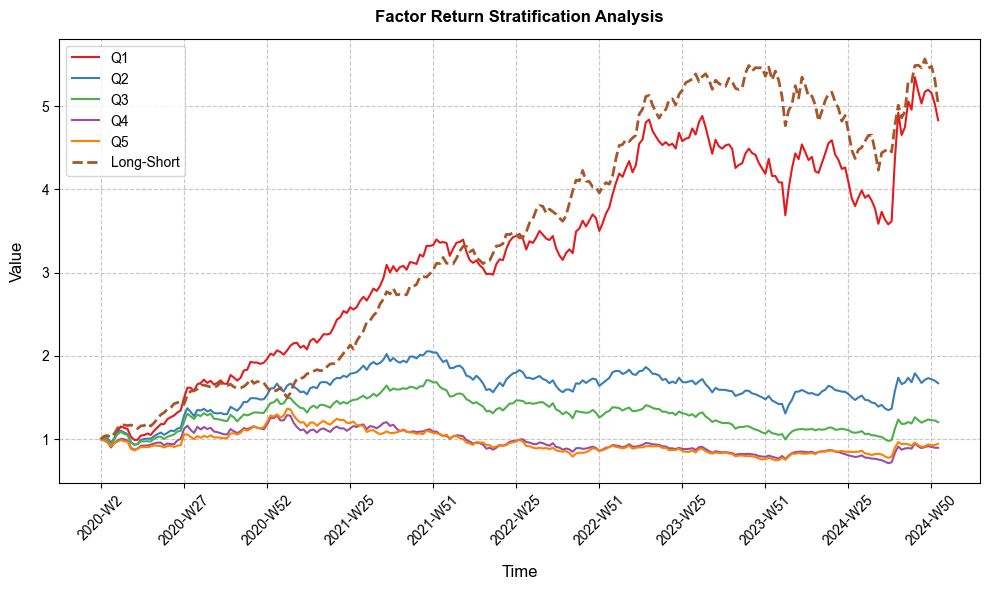

In [205]:
plt.figure(figsize=(10, 6))

# 将多重索引转换为字符串格式用于绘图
dates = [f"{year}-W{week}" for year, week in results['Cumulative Returns'].index]

# 绘制累积收益曲线
plt.plot(range(len(dates)), results['Cumulative Returns']['Q1'], label='Q1', color = color_map(0), linewidth=1.5)
plt.plot(range(len(dates)), results['Cumulative Returns']['Q2'], label='Q2', color = color_map(1), linewidth=1.5)
plt.plot(range(len(dates)), results['Cumulative Returns']['Q3'], label='Q3', color = color_map(2), linewidth=1.5)
plt.plot(range(len(dates)), results['Cumulative Returns']['Q4'], label='Q4', color = color_map(3), linewidth=1.5)
plt.plot(range(len(dates)), results['Cumulative Returns']['Q5'], label='Q5', color = color_map(4), linewidth=1.5)

# 使用虚线绘制多空组合
plt.plot(range(len(dates)), results['Cumulative Returns']['Long_Short'],
         label="Long-Short", linewidth=2, linestyle='--', color=color_map(6))

plt.title('Factor Return Stratification Analysis', pad=12, fontproperties=bold_font)
plt.xlabel('Time', labelpad=12, fontproperties=regular_font)
plt.ylabel('Value', labelpad=12, fontproperties=regular_font)

step = len(dates) // 10
plt.xticks(range(0, len(dates), step), dates[::step], rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper left', prop=legend_font)
plt.tight_layout()

plt.show()

In [206]:
def calculate_portfolio_significance(portfolio_returns):
    """
    计算每个投资组合的平均收益率和统计显著性
    """
    import scipy.stats as stats
    
    portfolio_stats = {}
    
    for col in portfolio_returns.columns:

        returns = portfolio_returns[col].dropna()
        
        # 计算平均收益
        mean_return = returns.mean()
        
        # 计算t统计量和p值
        t_stat, p_value = stats.ttest_1samp(returns, 0)
        
        # 计算标准差
        std_dev = returns.std()
        
        # 计算标准误
        std_error = std_dev / np.sqrt(len(returns))
        
        # 确定显著性标记
        sig_mark = ''
        if p_value < 0.01:
            sig_mark = '***'
        elif p_value < 0.05:
            sig_mark = '**'
        elif p_value < 0.10:
            sig_mark = '*'
        
        portfolio_stats[col] = {
            'Mean Return': mean_return,
            'T-stat': t_stat,
            'P-value': p_value,
            'Significance': sig_mark,
            'Std Error': std_error
        }
    
    # 转换为DataFrame
    stats_df = pd.DataFrame(portfolio_stats).T
    
    # 格式化结果
    formatted_df = pd.DataFrame({
        'Mean Return(%)': (stats_df['Mean Return'] * 100).round(2),
        'T-statistic': stats_df['T-stat'].round(2),
        'Std Error(%)': (stats_df['Std Error'] * 100).round(2),
        'P-value': stats_df['P-value'].round(3),
        'Sig.': stats_df['Significance']
    })
    
    return formatted_df

# 示例使用
stats_results = calculate_portfolio_significance(portfolio_returns)
print("\n投资组合收益显著性分析:")
print("=" * 80)
print(stats_results)
print("\n注: *** p<0.01, ** p<0.05, * p<0.1")


投资组合收益显著性分析:
   Mean Return(%) T-statistic Std Error(%)   P-value Sig.
Q1       0.686402    3.253775     0.210956  0.001295  ***
Q2         0.2565    1.365033     0.187907   0.17346     
Q3       0.117808    0.682699     0.172562  0.495424     
Q4      -0.001252   -0.007053     0.177498  0.994379     
Q5       0.012232    0.073908     0.165504  0.941142     

注: *** p<0.01, ** p<0.05, * p<0.1


In [207]:
portfolio_returns = create_quintile_portfolios(weekly_data, factor='PRC')
stats_results = calculate_portfolio_significance(portfolio_returns)
print("\n投资组合收益显著性分析 - PRC:")
print("=" * 80)
print(stats_results)
print("\n注: *** p<0.01, ** p<0.05, * p<0.1")

portfolio_returns = create_quintile_portfolios(weekly_data, factor='MAXDPRC')
stats_results = calculate_portfolio_significance(portfolio_returns)
print("\n投资组合收益显著性分析 - MAXDPRC:")
print("=" * 80)
print(stats_results)
print("\n注: *** p<0.01, ** p<0.05, * p<0.1")

portfolio_returns = create_quintile_portfolios(weekly_data, factor='r_1_0')
stats_results = calculate_portfolio_significance(portfolio_returns)
print("\n投资组合收益显著性分析 - r_1_0:")
print("=" * 80)
print(stats_results)
print("\n注: *** p<0.01, ** p<0.05, * p<0.1")

portfolio_returns = create_quintile_portfolios(weekly_data, factor='r_2_0')
stats_results = calculate_portfolio_significance(portfolio_returns)
print("\n投资组合收益显著性分析 - r_2_0:")
print("=" * 80)
print(stats_results)
print("\n注: *** p<0.01, ** p<0.05, * p<0.1")

portfolio_returns = create_quintile_portfolios(weekly_data, factor='r_3_0')
stats_results = calculate_portfolio_significance(portfolio_returns)
print("\n投资组合收益显著性分析 - r_3_0:")
print("=" * 80)
print(stats_results)
print("\n注: *** p<0.01, ** p<0.05, * p<0.1")

portfolio_returns = create_quintile_portfolios(weekly_data, factor='r_4_0')
stats_results = calculate_portfolio_significance(portfolio_returns)
print("\n投资组合收益显著性分析 - r_4_0:")
print("=" * 80)
print(stats_results)
print("\n注: *** p<0.01, ** p<0.05, * p<0.1")

portfolio_returns = create_quintile_portfolios(weekly_data, factor='VOL')
stats_results = calculate_portfolio_significance(portfolio_returns)
print("\n投资组合收益显著性分析 - VOL:")
print("=" * 80)
print(stats_results)
print("\n注: *** p<0.01, ** p<0.05, * p<0.1")

portfolio_returns = create_quintile_portfolios(weekly_data, factor='PRCVOL')
stats_results = calculate_portfolio_significance(portfolio_returns)
print("\n投资组合收益显著性分析 - PRCVOL:")
print("=" * 80)
print(stats_results)
print("\n注: *** p<0.01, ** p<0.05, * p<0.1")

portfolio_returns = create_quintile_portfolios(weekly_data, factor='VOLSCALED')
stats_results = calculate_portfolio_significance(portfolio_returns)
print("\n投资组合收益显著性分析 - VOLSCALED:")
print("=" * 80)
print(stats_results)
print("\n注: *** p<0.01, ** p<0.05, * p<0.1")


投资组合收益显著性分析 - PRC:
   Mean Return(%) T-statistic Std Error(%)   P-value Sig.
Q1       0.257658    1.609001     0.160135  0.108868     
Q2        0.23726     1.31088     0.180993  0.191092     
Q3       0.258607    1.351759     0.191311  0.177665     
Q4        0.20185    1.015275     0.198813  0.310949     
Q5       0.119959    0.512354     0.234133  0.608852     

注: *** p<0.01, ** p<0.05, * p<0.1

投资组合收益显著性分析 - MAXDPRC:
   Mean Return(%) T-statistic Std Error(%)   P-value Sig.
Q1       0.253869    1.589949     0.159671    0.1131     
Q2       0.250685    1.380997     0.181524  0.168503     
Q3       0.239781    1.256922     0.190769  0.209946     
Q4       0.207904    1.041478     0.199624  0.298652     
Q5        0.12275     0.52415     0.234189  0.600635     

注: *** p<0.01, ** p<0.05, * p<0.1

投资组合收益显著性分析 - r_1_0:
   Mean Return(%) T-statistic Std Error(%)   P-value Sig.
Q1       0.178364    0.809728     0.220277  0.418863     
Q2       0.172116    0.942683     0.182581   0.34675

In [208]:
# 检查重复索引
weekly_factors = weekly_factors[~weekly_factors.index.duplicated(keep='first')]

# 验证是否还有重复
print("\nAfter removing duplicates:")
print("Index is unique:", weekly_factors.index.is_unique)

# 现在进行合并
weekly_data_with_factors = weekly_data.join(weekly_factors)


After removing duplicates:
Index is unique: True


In [210]:
portfolio_returns = create_quintile_portfolios(weekly_data_with_factors, factor='BETA')
stats_results = calculate_portfolio_significance(portfolio_returns)

print("\n投资组合收益显著性分析 - BETA:")
print("=" * 80)
print(stats_results)
print("\n注: *** p<0.01, ** p<0.05, * p<0.1")

portfolio_returns = create_quintile_portfolios(weekly_data_with_factors, factor='BETA2')
stats_results = calculate_portfolio_significance(portfolio_returns)

print("\n投资组合收益显著性分析 - BETA2:")
print("=" * 80)
print(stats_results)
print("\n注: *** p<0.01, ** p<0.05, * p<0.1")

portfolio_returns = create_quintile_portfolios(weekly_data_with_factors, factor='IDIOVOL')
stats_results = calculate_portfolio_significance(portfolio_returns)

print("\n投资组合收益显著性分析 - IDIOVOL:")
print("=" * 80)
print(stats_results)
print("\n注: *** p<0.01, ** p<0.05, * p<0.1")


投资组合收益显著性分析 - BETA:
   Mean Return(%) T-statistic Std Error(%)   P-value Sig.
Q1       0.200102    1.196623     0.167222  0.233081     
Q2      -0.017311   -0.090439     0.191406  0.928042     
Q3        0.01137    0.054436     0.208876   0.95665     
Q4      -0.086505   -0.369348     0.234209  0.712317     
Q5       0.009893    0.037736     0.262165  0.969942     

注: *** p<0.01, ** p<0.05, * p<0.1

投资组合收益显著性分析 - BETA2:
   Mean Return(%) T-statistic Std Error(%)   P-value Sig.
Q1       0.200102    1.196623     0.167222  0.233081     
Q2      -0.017311   -0.090439     0.191406  0.928042     
Q3        0.01137    0.054436     0.208876   0.95665     
Q4      -0.086505   -0.369348     0.234209  0.712317     
Q5       0.009893    0.037736     0.262165  0.969942     

注: *** p<0.01, ** p<0.05, * p<0.1

投资组合收益显著性分析 - IDIOVOL:
   Mean Return(%) T-statistic Std Error(%)   P-value Sig.
Q1       0.235931     1.37743     0.171283  0.170149     
Q2       0.060807     0.30672     0.198251  0.75942